###Installation of Libraries###

In [1]:
%%capture
!pip install category_encoders==2.*
!pip install pandas_profiling==2.*
!pip install pdpbox

In [2]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor, GradientBoostingClassifier
from xgboost import XGBClassifier, XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report, roc_auc_score, roc_curve, plot_confusion_matrix, plot_roc_curve
from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot
from sklearn.preprocessing import StandardScaler
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score # k-fold CV
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # Hyperparameter tuning
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas_profiling import ProfileReport

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
#importing my dataset
from google.colab import files
uploaded = files.upload()

Saving DataCoSupplyChainDataset.csv to DataCoSupplyChainDataset.csv


# Wrangling & Feature Engineering
------


In [4]:
filepath = 'DataCoSupplyChainDataset.csv'

In [5]:
def wrangle(filepath):
  df = pd.read_csv(filepath,
                   encoding='latin-1',
                   parse_dates=['order date (DateOrders)'],
                   index_col='order date (DateOrders)').sort_index()

  # Drop constant and NaN columns
  df.drop(columns=['Order Zipcode', 'Product Description', 'Product Status'], inplace=True)

  # Drop private information columns(also happen to be constant columns)
  df.drop(columns=['Customer Email','Customer Password'], inplace=True)

  # Drop column with links to images
  df.drop(columns='Product Image', inplace=True)

  # Drop HCCCs
  cutoff = 1100
  drop_cols = [col for col in df.select_dtypes('object').columns
              if df[col].nunique() > cutoff]
  df.drop(columns=drop_cols, inplace=True)
  
  # Drop HCC, irrelevant columns, & unique identifier columns
  df.drop(columns=['Customer Fname','Customer Id', 'Order Item Id', 'Order Id','Order Customer Id', 'Customer Zipcode', 'Customer City', 'Order State'], inplace=True)

  # Drop column that will cause data leakage
  df.drop(columns=['Delivery Status','Days for shipping (real)', 'Days for shipment (scheduled)'], inplace=True)

  # Drop remaining NaN rows
  df.dropna(inplace=True)

  return df

df = wrangle(filepath)

# EDA
-----

In [6]:
#Big picture EDA with profile report to help me conduct wrangling and feature engineering
ProfileReport(df, minimal= True)

Summarize dataset:   0%|          | 0/40 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [7]:
df.head()

,Type,Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Category Name,Customer Country,Customer Segment,Customer State,Department Id,Department Name,Latitude,Longitude,Market,Order Country,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Shipping Mode
order date (DateOrders),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,CASH,88.790001,239.979996,0,43,Camping & Hiking,EE. UU.,Consumer,NC,7,Fan Shop,35.776661,-81.362625,LATAM,México,957,60.00,0.20,299.980011,0.37,1,299.980011,239.979996,88.790001,Central America,CLOSED,957,43,Diamondback Women's Serene Classic Comfort Bi,299.980011,Standard Class
2015-01-01 00:21:00,PAYMENT,91.180000,193.990005,0,48,Water Sports,EE. UU.,Consumer,IL,7,Fan Shop,41.832722,-87.980484,LATAM,Colombia,1073,6.00,0.03,199.990005,0.47,1,199.990005,193.990005,91.180000,South America,PENDING_PAYMENT,1073,48,Pelican Sunstream 100 Kayak,199.990005,Standard Class
2015-01-01 00:21:00,PAYMENT,68.250000,227.500000,0,24,Women's Apparel,EE. UU.,Consumer,IL,5,Golf,41.832722,-87.980484,LATAM,Colombia,502,22.50,0.09,50.000000,0.30,5,250.000000,227.500000,68.250000,South America,PENDING_PAYMENT,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,Standard Class
2015-01-01 00:21:00,PAYMENT,36.470001,107.889999,0,18,Men's Footwear,EE. UU.,Consumer,IL,4,Apparel,41.832722,-87.980484,LATAM,Colombia,403,22.10,0.17,129.990005,0.34,1,129.990005,107.889999,36.470001,South America,PENDING_PAYMENT,403,18,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,Standard Class
2015-01-01 01:03:00,CASH,33.590000,159.940002,1,46,Indoor/Outdoor Games,EE. UU.,Home Office,TX,7,Fan Shop,29.520010,-98.637413,LATAM,Colombia,1014,39.98,0.20,49.980000,0.21,4,199.919998,159.940002,33.590000,South America,CLOSED,1014,46,O'Brien Men's Neoprene Life Vest,49.980000,Standard Class


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180519 entries, 2015-01-01 00:00:00 to 2018-01-31 23:38:00
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Type                      180519 non-null  object 
 1   Benefit per order         180519 non-null  float64
 2   Sales per customer        180519 non-null  float64
 3   Late_delivery_risk        180519 non-null  int64  
 4   Category Id               180519 non-null  int64  
 5   Category Name             180519 non-null  object 
 6   Customer Country          180519 non-null  object 
 7   Customer Segment          180519 non-null  object 
 8   Customer State            180519 non-null  object 
 9   Department Id             180519 non-null  int64  
 10  Department Name           180519 non-null  object 
 11  Latitude                  180519 non-null  float64
 12  Longitude                 180519 non-null  float64
 13  Market    

In [9]:
df.isnull().sum()

Type                        0
Benefit per order           0
Sales per customer          0
Late_delivery_risk          0
Category Id                 0
Category Name               0
Customer Country            0
Customer Segment            0
Customer State              0
Department Id               0
Department Name             0
Latitude                    0
Longitude                   0
Market                      0
Order Country               0
Order Item Cardprod Id      0
Order Item Discount         0
Order Item Discount Rate    0
Order Item Product Price    0
Order Item Profit Ratio     0
Order Item Quantity         0
Sales                       0
Order Item Total            0
Order Profit Per Order      0
Order Region                0
Order Status                0
Product Card Id             0
Product Category Id         0
Product Name                0
Product Price               0
Shipping Mode               0
dtype: int64

In [10]:
df.head()

,Type,Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Category Name,Customer Country,Customer Segment,Customer State,Department Id,Department Name,Latitude,Longitude,Market,Order Country,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Shipping Mode
order date (DateOrders),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,CASH,88.790001,239.979996,0,43,Camping & Hiking,EE. UU.,Consumer,NC,7,Fan Shop,35.776661,-81.362625,LATAM,México,957,60.00,0.20,299.980011,0.37,1,299.980011,239.979996,88.790001,Central America,CLOSED,957,43,Diamondback Women's Serene Classic Comfort Bi,299.980011,Standard Class
2015-01-01 00:21:00,PAYMENT,91.180000,193.990005,0,48,Water Sports,EE. UU.,Consumer,IL,7,Fan Shop,41.832722,-87.980484,LATAM,Colombia,1073,6.00,0.03,199.990005,0.47,1,199.990005,193.990005,91.180000,South America,PENDING_PAYMENT,1073,48,Pelican Sunstream 100 Kayak,199.990005,Standard Class
2015-01-01 00:21:00,PAYMENT,68.250000,227.500000,0,24,Women's Apparel,EE. UU.,Consumer,IL,5,Golf,41.832722,-87.980484,LATAM,Colombia,502,22.50,0.09,50.000000,0.30,5,250.000000,227.500000,68.250000,South America,PENDING_PAYMENT,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,Standard Class
2015-01-01 00:21:00,PAYMENT,36.470001,107.889999,0,18,Men's Footwear,EE. UU.,Consumer,IL,4,Apparel,41.832722,-87.980484,LATAM,Colombia,403,22.10,0.17,129.990005,0.34,1,129.990005,107.889999,36.470001,South America,PENDING_PAYMENT,403,18,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,Standard Class
2015-01-01 01:03:00,CASH,33.590000,159.940002,1,46,Indoor/Outdoor Games,EE. UU.,Home Office,TX,7,Fan Shop,29.520010,-98.637413,LATAM,Colombia,1014,39.98,0.20,49.980000,0.21,4,199.919998,159.940002,33.590000,South America,CLOSED,1014,46,O'Brien Men's Neoprene Life Vest,49.980000,Standard Class


In [28]:
df['Late_delivery_risk'].value_counts(normalize=True)*100

1    54.829132
0    45.170868
Name: Late_delivery_risk, dtype: float64

In [68]:
df.columns

Index(['Type', 'Benefit per order', 'Sales per customer', 'Late_delivery_risk',
       'Category Id', 'Category Name', 'Customer Country', 'Customer Segment',
       'Customer State', 'Department Id', 'Department Name', 'Latitude',
       'Longitude', 'Market', 'Order Country', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Card Id', 'Product Category Id', 'Product Name',
       'Product Price'],
      dtype='object')

In [29]:
df.columns.nunique()

31

In [ ]:

colnunique

,Unique Values
Column,
Type,4
Days for shipping (real),7
Days for shipment (scheduled),4
Benefit per order,21998
Sales per customer,2927
Delivery Status,4
Late_delivery_risk,2
Category Id,51
Category Name,50


In [30]:
print(df.info())
display(df.describe())
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180519 entries, 2015-01-01 00:00:00 to 2018-01-31 23:38:00
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Type                      180519 non-null  object 
 1   Benefit per order         180519 non-null  float64
 2   Sales per customer        180519 non-null  float64
 3   Late_delivery_risk        180519 non-null  int64  
 4   Category Id               180519 non-null  int64  
 5   Category Name             180519 non-null  object 
 6   Customer Country          180519 non-null  object 
 7   Customer Segment          180519 non-null  object 
 8   Customer State            180519 non-null  object 
 9   Department Id             180519 non-null  int64  
 10  Department Name           180519 non-null  object 
 11  Latitude                  180519 non-null  float64
 12  Longitude                 180519 non-null  float64
 13  Market    

,Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Department Id,Latitude,Longitude,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Product Card Id,Product Category Id,Product Price
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000
mean,21.974989,183.107609,0.548291,31.851451,5.443460,29.719955,-84.915675,692.509764,20.664741,0.101668,141.232550,0.120647,2.127638,203.772096,183.107609,21.974989,692.509764,31.851451,141.232550
std,104.433526,120.043670,0.497664,15.640064,1.629246,9.813646,21.433241,336.446807,21.800901,0.070415,139.732492,0.466796,1.453451,132.273077,120.043670,104.433526,336.446807,15.640064,139.732492
min,-4274.979980,7.490000,0.000000,2.000000,2.000000,-33.937553,-158.025986,19.000000,0.000000,0.000000,9.990000,-2.750000,1.000000,9.990000,7.490000,-4274.979980,19.000000,2.000000,9.990000
25%,7.000000,104.379997,0.000000,18.000000,4.000000,18.265432,-98.446312,403.000000,5.400000,0.040000,50.000000,0.080000,1.000000,119.980003,104.379997,7.000000,403.000000,18.000000,50.000000
50%,31.520000,163.990005,1.000000,29.000000,5.000000,33.144863,-76.847908,627.000000,14.000000,0.100000,59.990002,0.270000,1.000000,199.919998,163.990005,31.520000,627.000000,29.000000,59.990002
75%,64.800003,247.399994,1.000000,45.000000,7.000000,39.279617,-66.370583,1004.000000,29.990000,0.160000,199.990005,0.360000,3.000000,299.950012,247.399994,64.800003,1004.000000,45.000000,199.990005
max,911.799988,1939.989990,1.000000,76.000000,12.000000,48.781933,115.263077,1363.000000,500.000000,0.250000,1999.989990,0.500000,5.000000,1999.989990,1939.989990,911.799988,1363.000000,76.000000,1999.989990


Type                        0
Benefit per order           0
Sales per customer          0
Late_delivery_risk          0
Category Id                 0
Category Name               0
Customer Country            0
Customer Segment            0
Customer State              0
Department Id               0
Department Name             0
Latitude                    0
Longitude                   0
Market                      0
Order Country               0
Order Item Cardprod Id      0
Order Item Discount         0
Order Item Discount Rate    0
Order Item Product Price    0
Order Item Profit Ratio     0
Order Item Quantity         0
Sales                       0
Order Item Total            0
Order Profit Per Order      0
Order Region                0
Order Status                0
Product Card Id             0
Product Category Id         0
Product Name                0
Product Price               0
Shipping Mode               0
dtype: int64


In [16]:
df.columns.nunique()

33

In [17]:
#In the next couple of cells, I am building a dataframe with column names as the index and number of unique values in each feature as the column in order to identify high cardinality columns
print(df.columns)
print(df.columns.nunique())


Index(['Type', 'Days for shipment (scheduled)', 'Benefit per order',
       'Sales per customer', 'Late_delivery_risk', 'Category Id',
       'Category Name', 'Customer Country', 'Customer Segment',
       'Customer State', 'Department Id', 'Department Name', 'Latitude',
       'Longitude', 'Market', 'Order Country', 'Order Item Cardprod Id',
       'Order Item Discount', 'Order Item Discount Rate',
       'Order Item Product Price', 'Order Item Profit Ratio',
       'Order Item Quantity', 'Sales', 'Order Item Total',
       'Order Profit Per Order', 'Order Region', 'Order State', 'Order Status',
       'Product Card Id', 'Product Category Id', 'Product Name',
       'Product Price', 'Shipping Mode'],
      dtype='object')
33


In [ ]:
x = ['Type', 'Days for shipping (real)', 'Days for shipment (scheduled)',
       'Benefit per order', 'Sales per customer', 'Delivery Status',
       'Late_delivery_risk', 'Category Id', 'Category Name', 'Customer City',
       'Customer Country', 'Customer Fname', 'Customer Id', 'Customer Lname',
       'Customer Segment', 'Customer State', 'Customer Street',
       'Customer Zipcode', 'Department Id', 'Department Name', 'Latitude',
       'Longitude', 'Market', 'Order City', 'Order Country',
       'Order Customer Id', 'order date (DateOrders)', 'Order Id',
       'Order Item Cardprod Id', 'Order Item Discount',
       'Order Item Discount Rate', 'Order Item Id', 'Order Item Product Price',
       'Order Item Profit Ratio', 'Order Item Quantity', 'Sales',
       'Order Item Total', 'Order Profit Per Order', 'Order Region',
       'Order State', 'Order Status', 'Product Card Id', 'Product Category Id',
       'Product Image', 'Product Name', 'Product Price', 'Product Status',
       'shipping date (DateOrders)', 'Shipping Mode']

list(x)

['Type',
 'Days for shipping (real)',
 'Days for shipment (scheduled)',
 'Benefit per order',
 'Sales per customer',
 'Delivery Status',
 'Late_delivery_risk',
 'Category Id',
 'Category Name',
 'Customer City',
 'Customer Country',
 'Customer Fname',
 'Customer Id',
 'Customer Lname',
 'Customer Segment',
 'Customer State',
 'Customer Street',
 'Customer Zipcode',
 'Department Id',
 'Department Name',
 'Latitude',
 'Longitude',
 'Market',
 'Order City',
 'Order Country',
 'Order Customer Id',
 'order date (DateOrders)',
 'Order Id',
 'Order Item Cardprod Id',
 'Order Item Discount',
 'Order Item Discount Rate',
 'Order Item Id',
 'Order Item Product Price',
 'Order Item Profit Ratio',
 'Order Item Quantity',
 'Sales',
 'Order Item Total',
 'Order Profit Per Order',
 'Order Region',
 'Order State',
 'Order Status',
 'Product Card Id',
 'Product Category Id',
 'Product Image',
 'Product Name',
 'Product Price',
 'Product Status',
 'shipping date (DateOrders)',
 'Shipping Mode']

In [ ]:
for var in x:
  nunique = print(df[var].nunique())
  nunique


4
7
4
21998
2927
4
2
51
50
563
2
782
20652
1109
3
46
7458
995
11
11
11250
4487
5
3597
164
20652
65752
65752
118
1017
18
180519
75
162
5
193
2927
21998
23
1089
9
118
51
118
118
75
1
63701
4


In [ ]:
nunique = ['4','7','4','21998','2927','4','2','51','50','563','2','782','20652','1109','3','46','7458','995','11','11','11250','4487','5','3597','164','20652','65752','65752','118','1017','18','180519','75','162','5','193','2927','21998','23','1089','9','118','51','118','118','75','1','63701','4']
list(nunique)

['4',
 '7',
 '4',
 '21998',
 '2927',
 '4',
 '2',
 '51',
 '50',
 '563',
 '2',
 '782',
 '20652',
 '1109',
 '3',
 '46',
 '7458',
 '995',
 '11',
 '11',
 '11250',
 '4487',
 '5',
 '3597',
 '164',
 '20652',
 '65752',
 '65752',
 '118',
 '1017',
 '18',
 '180519',
 '75',
 '162',
 '5',
 '193',
 '2927',
 '21998',
 '23',
 '1089',
 '9',
 '118',
 '51',
 '118',
 '118',
 '75',
 '1',
 '63701',
 '4']

In [ ]:
nunique = pd.DataFrame(nunique)
display(nunique)
columns = pd.DataFrame(df.columns)
display(columns)

print(nunique.shape)
print(columns.shape)
colnunique = pd.concat([columns, nunique], axis=1)


,0
0,4
1,7
2,4
3,21998
4,2927
5,4
6,2
7,51
8,50
9,563


,0
0,Type
1,Days for shipping (real)
2,Days for shipment (scheduled)
3,Benefit per order
4,Sales per customer
5,Delivery Status
6,Late_delivery_risk
7,Category Id
8,Category Name
9,Customer City


(49, 1)
(49, 1)


In [ ]:
colnunique.columns = ['Column', 'Unique Values']



In [ ]:
colnunique.set_index('Column', inplace=True)

In [ ]:
colnunique

,Unique Values
Column,
Type,4
Days for shipping (real),7
Days for shipment (scheduled),4
Benefit per order,21998
Sales per customer,2927
Delivery Status,4
Late_delivery_risk,2
Category Id,51
Category Name,50


In [ ]:
print(dataco.info())
display(dataco.describe())
print(dataco.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180519 entries, 0 to 180518
Data columns (total 53 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Type                           180519 non-null  object 
 1   Days for shipping (real)       180519 non-null  int64  
 2   Days for shipment (scheduled)  180519 non-null  int64  
 3   Benefit per order              180519 non-null  float64
 4   Sales per customer             180519 non-null  float64
 5   Delivery Status                180519 non-null  object 
 6   Late_delivery_risk             180519 non-null  int64  
 7   Category Id                    180519 non-null  int64  
 8   Category Name                  180519 non-null  object 
 9   Customer City                  180519 non-null  object 
 10  Customer Country               180519 non-null  object 
 11  Customer Email                 180519 non-null  object 
 12  Customer Fname                

,Days for shipping (real),Days for shipment (scheduled),Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Customer Id,Customer Zipcode,Department Id,Latitude,Longitude,Order Customer Id,Order Id,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Id,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Zipcode,Product Card Id,Product Category Id,Product Description,Product Price,Product Status
count,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180516.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,180519.000000,24840.000000,180519.000000,180519.000000,0.0,180519.000000,180519.0
mean,3.497654,2.931847,21.974989,183.107609,0.548291,31.851451,6691.379495,35921.126914,5.443460,29.719955,-84.915675,6691.379495,36221.894903,692.509764,20.664741,0.101668,90260.000000,141.232550,0.120647,2.127638,203.772096,183.107609,21.974989,55426.132327,692.509764,31.851451,NaN,141.232550,0.0
std,1.623722,1.374449,104.433526,120.043670,0.497664,15.640064,4162.918106,37542.461122,1.629246,9.813646,21.433241,4162.918106,21045.379569,336.446807,21.800901,0.070415,52111.490959,139.732492,0.466796,1.453451,132.273077,120.043670,104.433526,31919.279101,336.446807,15.640064,NaN,139.732492,0.0
min,0.000000,0.000000,-4274.979980,7.490000,0.000000,2.000000,1.000000,603.000000,2.000000,-33.937553,-158.025986,1.000000,1.000000,19.000000,0.000000,0.000000,1.000000,9.990000,-2.750000,1.000000,9.990000,7.490000,-4274.979980,1040.000000,19.000000,2.000000,NaN,9.990000,0.0
25%,2.000000,2.000000,7.000000,104.379997,0.000000,18.000000,3258.500000,725.000000,4.000000,18.265432,-98.446312,3258.500000,18057.000000,403.000000,5.400000,0.040000,45130.500000,50.000000,0.080000,1.000000,119.980003,104.379997,7.000000,23464.000000,403.000000,18.000000,NaN,50.000000,0.0
50%,3.000000,4.000000,31.520000,163.990005,1.000000,29.000000,6457.000000,19380.000000,5.000000,33.144863,-76.847908,6457.000000,36140.000000,627.000000,14.000000,0.100000,90260.000000,59.990002,0.270000,1.000000,199.919998,163.990005,31.520000,59405.000000,627.000000,29.000000,NaN,59.990002,0.0
75%,5.000000,4.000000,64.800003,247.399994,1.000000,45.000000,9779.000000,78207.000000,7.000000,39.279617,-66.370583,9779.000000,54144.000000,1004.000000,29.990000,0.160000,135389.500000,199.990005,0.360000,3.000000,299.950012,247.399994,64.800003,90008.000000,1004.000000,45.000000,NaN,199.990005,0.0
max,6.000000,4.000000,911.799988,1939.989990,1.000000,76.000000,20757.000000,99205.000000,12.000000,48.781933,115.263077,20757.000000,77204.000000,1363.000000,500.000000,0.250000,180519.000000,1999.989990,0.500000,5.000000,1999.989990,1939.989990,911.799988,99301.000000,1363.000000,76.000000,NaN,1999.989990,0.0


Type                                  0
Days for shipping (real)              0
Days for shipment (scheduled)         0
Benefit per order                     0
Sales per customer                    0
Delivery Status                       0
Late_delivery_risk                    0
Category Id                           0
Category Name                         0
Customer City                         0
Customer Country                      0
Customer Email                        0
Customer Fname                        0
Customer Id                           0
Customer Lname                        8
Customer Password                     0
Customer Segment                      0
Customer State                        0
Customer Street                       0
Customer Zipcode                      3
Department Id                         0
Department Name                       0
Latitude                              0
Longitude                             0
Market                                0


#Split Data#

--------

In [31]:
df.head()

,Type,Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Category Name,Customer Country,Customer Segment,Customer State,Department Id,Department Name,Latitude,Longitude,Market,Order Country,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Shipping Mode
order date (DateOrders),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,CASH,88.790001,239.979996,0,43,Camping & Hiking,EE. UU.,Consumer,NC,7,Fan Shop,35.776661,-81.362625,LATAM,México,957,60.00,0.20,299.980011,0.37,1,299.980011,239.979996,88.790001,Central America,CLOSED,957,43,Diamondback Women's Serene Classic Comfort Bi,299.980011,Standard Class
2015-01-01 00:21:00,PAYMENT,91.180000,193.990005,0,48,Water Sports,EE. UU.,Consumer,IL,7,Fan Shop,41.832722,-87.980484,LATAM,Colombia,1073,6.00,0.03,199.990005,0.47,1,199.990005,193.990005,91.180000,South America,PENDING_PAYMENT,1073,48,Pelican Sunstream 100 Kayak,199.990005,Standard Class
2015-01-01 00:21:00,PAYMENT,68.250000,227.500000,0,24,Women's Apparel,EE. UU.,Consumer,IL,5,Golf,41.832722,-87.980484,LATAM,Colombia,502,22.50,0.09,50.000000,0.30,5,250.000000,227.500000,68.250000,South America,PENDING_PAYMENT,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,Standard Class
2015-01-01 00:21:00,PAYMENT,36.470001,107.889999,0,18,Men's Footwear,EE. UU.,Consumer,IL,4,Apparel,41.832722,-87.980484,LATAM,Colombia,403,22.10,0.17,129.990005,0.34,1,129.990005,107.889999,36.470001,South America,PENDING_PAYMENT,403,18,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,Standard Class
2015-01-01 01:03:00,CASH,33.590000,159.940002,1,46,Indoor/Outdoor Games,EE. UU.,Home Office,TX,7,Fan Shop,29.520010,-98.637413,LATAM,Colombia,1014,39.98,0.20,49.980000,0.21,4,199.919998,159.940002,33.590000,South America,CLOSED,1014,46,O'Brien Men's Neoprene Life Vest,49.980000,Standard Class


In [32]:
print(df.index.min())
print(df.index.max())
print(df.info())
print(df.isnull().sum())

2015-01-01 00:00:00
2018-01-31 23:38:00
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180519 entries, 2015-01-01 00:00:00 to 2018-01-31 23:38:00
Data columns (total 31 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   Type                      180519 non-null  object 
 1   Benefit per order         180519 non-null  float64
 2   Sales per customer        180519 non-null  float64
 3   Late_delivery_risk        180519 non-null  int64  
 4   Category Id               180519 non-null  int64  
 5   Category Name             180519 non-null  object 
 6   Customer Country          180519 non-null  object 
 7   Customer Segment          180519 non-null  object 
 8   Customer State            180519 non-null  object 
 9   Department Id             180519 non-null  int64  
 10  Department Name           180519 non-null  object 
 11  Latitude                  180519 non-null  float64
 12  Longitude                 

In [12]:
target = 'Late_delivery_risk'
y = df[target]
X = df.drop(columns=target)

print(y.shape)
print(X.shape)

(180519,)
(180519, 30)


In [13]:
cutoff1 = '2017-09-01'
cutoff2 = '2017-04-01'
mask1 = X.index < cutoff1
mask2 = (X.index >= cutoff2) & (X.index < cutoff1)
mask3 = X.index < cutoff2

X_train, y_train = X.loc[mask3], y.loc[mask3]
X_val, y_val = X.loc[mask2], y.loc[mask2]
X_test, y_test = X.loc[~mask1], y.loc[~mask1]
CVX, CVy = X.loc[mask1], y.loc[mask1]

In [14]:
print('Training Dataset Info:')
print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_train index min & max:', X_train.index.min(), ', ', X_train.index.max())
print('y_train index min & max:', y_train.index.min(), ', ', y_train.index.max())
print('---------------------------')
print('Validation Dataset Info:')
print('X_val shape:', X_val.shape)
print('y_val shape:', y_val.shape)
print('X_val index min & max:', X_val.index.min(), ', ', X_val.index.max())
print('y_val index min & max:', y_val.index.min(), ', ', y_val.index.max())
print('---------------------------')
print('Testing Dataset Info:')
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)
print('X_test index min & max:', X_test.index.min(), ', ', X_test.index.max())
print('y_test index min & max:', y_test.index.min(), ', ', y_test.index.max())
print('---------------------------')
print('X & y CV (Train & Validation) Dataset Info:')
print('X_test shape:', CVX.shape)
print('y_test shape:', CVy.shape)
print('X_test index min & max:', CVX.index.min(), ', ', CVX.index.max())
print('y_test index min & max:', CVy.index.min(), ', ', CVy.index.max())

Training Dataset Info:
X_train shape: (140670, 30)
y_train shape: (140670,)
X_train index min & max: 2015-01-01 00:00:00 ,  2017-03-31 23:22:00
y_train index min & max: 2015-01-01 00:00:00 ,  2017-03-31 23:22:00
---------------------------
Validation Dataset Info:
X_val shape: (26103, 30)
y_val shape: (26103,)
X_val index min & max: 2017-04-01 00:04:00 ,  2017-08-31 23:41:00
y_val index min & max: 2017-04-01 00:04:00 ,  2017-08-31 23:41:00
---------------------------
Testing Dataset Info:
X_test shape: (13746, 30)
y_test shape: (13746,)
X_test index min & max: 2017-09-01 00:02:00 ,  2018-01-31 23:38:00
y_test index min & max: 2017-09-01 00:02:00 ,  2018-01-31 23:38:00
---------------------------
X & y CV (Train & Validation) Dataset Info:
X_test shape: (166773, 30)
y_test shape: (166773,)
X_test index min & max: 2015-01-01 00:00:00 ,  2017-08-31 23:41:00
y_test index min & max: 2015-01-01 00:00:00 ,  2017-08-31 23:41:00


#Establish a baseline#

----------------------

In [15]:
baseline = y_train.value_counts(normalize=True).max()
print('The baseline accuracy is: ', baseline)

The baseline accuracy is:  0.5491718205729722


#Build Model#

---------------------------

In [16]:
df.head()

,Type,Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Category Name,Customer Country,Customer Segment,Customer State,Department Id,Department Name,Latitude,Longitude,Market,Order Country,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Shipping Mode
order date (DateOrders),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,CASH,88.790001,239.979996,0,43,Camping & Hiking,EE. UU.,Consumer,NC,7,Fan Shop,35.776661,-81.362625,LATAM,México,957,60.00,0.20,299.980011,0.37,1,299.980011,239.979996,88.790001,Central America,CLOSED,957,43,Diamondback Women's Serene Classic Comfort Bi,299.980011,Standard Class
2015-01-01 00:21:00,PAYMENT,91.180000,193.990005,0,48,Water Sports,EE. UU.,Consumer,IL,7,Fan Shop,41.832722,-87.980484,LATAM,Colombia,1073,6.00,0.03,199.990005,0.47,1,199.990005,193.990005,91.180000,South America,PENDING_PAYMENT,1073,48,Pelican Sunstream 100 Kayak,199.990005,Standard Class
2015-01-01 00:21:00,PAYMENT,68.250000,227.500000,0,24,Women's Apparel,EE. UU.,Consumer,IL,5,Golf,41.832722,-87.980484,LATAM,Colombia,502,22.50,0.09,50.000000,0.30,5,250.000000,227.500000,68.250000,South America,PENDING_PAYMENT,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,Standard Class
2015-01-01 00:21:00,PAYMENT,36.470001,107.889999,0,18,Men's Footwear,EE. UU.,Consumer,IL,4,Apparel,41.832722,-87.980484,LATAM,Colombia,403,22.10,0.17,129.990005,0.34,1,129.990005,107.889999,36.470001,South America,PENDING_PAYMENT,403,18,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,Standard Class
2015-01-01 01:03:00,CASH,33.590000,159.940002,1,46,Indoor/Outdoor Games,EE. UU.,Home Office,TX,7,Fan Shop,29.520010,-98.637413,LATAM,Colombia,1014,39.98,0.20,49.980000,0.21,4,199.919998,159.940002,33.590000,South America,CLOSED,1014,46,O'Brien Men's Neoprene Life Vest,49.980000,Standard Class


###Logistic Regression###

In [17]:
modellr = make_pipeline(
    OneHotEncoder(use_cat_names=True), #Encode categorical values
    StandardScaler(), #re-scales all features  
    LogisticRegression()   
)

modellr.fit(X_train, y_train)

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(cols=['Type', 'Category Name',
                                     'Customer Country', 'Customer Segment',
                                     'Customer State', 'Department Name',
                                     'Market', 'Order Country', 'Order Region',
                                     'Order Status', 'Product Name',
                                     'Shipping Mode'],
                               use_cat_names=True)),
                ('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression())])

###Random Forest Classification###

In [18]:
modelrf = make_pipeline(
    OrdinalEncoder(),
    RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=10, n_estimators=10, max_samples=1.0)
)

modelrf.fit(X_train,y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Type', 'Category Name',
                                      'Customer Country', 'Customer Segment',
                                      'Customer State', 'Department Name',
                                      'Market', 'Order Country', 'Order Region',
                                      'Order Status', 'Product Name',
                                      'Shipping Mode'],
                                mapping=[{'col': 'Type',
                                          'data_type': dtype('O'),
                                          'mapping': CASH        1
PAYMENT     2
DEBIT       3
TRANSFER    4
NaN        -2
dtype: int64},
                                         {'col': 'Category Name...
Under Armour Women's Micro G Skulpt Running S    52
Hirzl Women's Hybrid Golf Glove                  53
Team Golf St. Louis Cardinals Putter Grip        54
NaN                                              -2
dtype

###XGBClassification###

In [19]:
modelxgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(random_state=42, n_jobs=-1, learning_rate=.01) #n_estimators=? & learning_rate=.1,.01,.02
)

modelxgb.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Type', 'Category Name',
                                      'Customer Country', 'Customer Segment',
                                      'Customer State', 'Department Name',
                                      'Market', 'Order Country', 'Order Region',
                                      'Order Status', 'Product Name',
                                      'Shipping Mode'],
                                mapping=[{'col': 'Type',
                                          'data_type': dtype('O'),
                                          'mapping': CASH        1
PAYMENT     2
DEBIT       3
TRANSFER    4
NaN        -2
dtype: int64},
                                         {'col': 'Category Name...
adidas Men's F10 Messi TRX FG Soccer Cleat       51
Under Armour Women's Micro G Skulpt Running S    52
Hirzl Women's Hybrid Golf Glove                  53
Team Golf St. Louis Cardinals Putter Grip        54
NaN  

In [35]:
#Performing further hyperparameter tuning on my xgbclassifier model using a randomized cv search
CVmodelxgb = make_pipeline(
    OrdinalEncoder(),
    XGBClassifier(random_state=42, n_jobs=-1, learning_rate=.01)
)

print('RandomizedSearchCV:')
print()
param_grid = {
    'xgbclassifier__n_estimators': np.arange(25,125,25),
    'xgbclassifier__max_depth': np.arange(3,10,2)
}

modelxgbrs = RandomizedSearchCV(
    CVmodelxgb,
    param_distributions = param_grid,
    cv = 5,
    n_jobs = -1,
    verbose = 1,
    n_iter = 5
)

RandomizedSearchCV:



In [36]:
modelxgbrs.fit(CVX,CVy)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('ordinalencoder',
                                              OrdinalEncoder()),
                                             ('xgbclassifier',
                                              XGBClassifier(learning_rate=0.01,
                                                            n_jobs=-1,
                                                            random_state=42))]),
                   n_iter=5, n_jobs=-1,
                   param_distributions={'xgbclassifier__max_depth': array([3, 5, 7, 9]),
                                        'xgbclassifier__n_estimators': array([ 25,  50,  75, 100])},
                   verbose=1)

In [37]:
modelxgbrs.best_params_

{'xgbclassifier__max_depth': 5, 'xgbclassifier__n_estimators': 75}

In [38]:
modelxgbrs.best_score_

0.7100549521386382

-----------------------

#Check Metrics#

---------------

In [20]:
print('Logistic Regression Model Metrics:')
print()
print('Training Accuracy: ', modellr.score(X_train,y_train))
print('Validation Accuracy: ', modellr.score(X_val, y_val))

Logistic Regression Model Metrics:

Training Accuracy:  0.7115802943058221
Validation Accuracy:  0.7069685476765123


In [21]:
print('Random Forest Classifier Model Metrics:')
print()
print('Training Accuracy: ', modelrf.score(X_train,y_train))
print('Validation Accuracy: ', modelrf.score(X_val, y_val))


Random Forest Classifier Model Metrics:

Training Accuracy:  0.7128030141465842
Validation Accuracy:  0.7087307972263724


In [22]:
print('XGBClassifier Model Metrics:')
print()
print('Training Accuracy: ', modelxgb.score(X_train,y_train))
print('Validation Accuracy: ', modelxgb.score(X_val, y_val))
print('Test Accuracy: ', modelxgb.score(X_test, y_test))

XGBClassifier Model Metrics:

Training Accuracy:  0.7103575744650601
Validation Accuracy:  0.7098800904110638
Test Accuracy:  0.7105339735195694


In [39]:
print('XGBClassifier Randomized Search Model Metrics:')
print()
print('Validation Accuracy: ', modelxgbrs.best_score_)
print('Test Accuracy: ', modelxgbrs.score(X_test, y_test))

XGBClassifier Randomized Search Model Metrics:

Validation Accuracy:  0.7100549521386382
Test Accuracy:  0.7128619234686454


#Tuning/Communication#

-----------------------------

In [24]:
df.head()

,Type,Benefit per order,Sales per customer,Late_delivery_risk,Category Id,Category Name,Customer Country,Customer Segment,Customer State,Department Id,Department Name,Latitude,Longitude,Market,Order Country,Order Item Cardprod Id,Order Item Discount,Order Item Discount Rate,Order Item Product Price,Order Item Profit Ratio,Order Item Quantity,Sales,Order Item Total,Order Profit Per Order,Order Region,Order Status,Product Card Id,Product Category Id,Product Name,Product Price,Shipping Mode
order date (DateOrders),,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,CASH,88.790001,239.979996,0,43,Camping & Hiking,EE. UU.,Consumer,NC,7,Fan Shop,35.776661,-81.362625,LATAM,México,957,60.00,0.20,299.980011,0.37,1,299.980011,239.979996,88.790001,Central America,CLOSED,957,43,Diamondback Women's Serene Classic Comfort Bi,299.980011,Standard Class
2015-01-01 00:21:00,PAYMENT,91.180000,193.990005,0,48,Water Sports,EE. UU.,Consumer,IL,7,Fan Shop,41.832722,-87.980484,LATAM,Colombia,1073,6.00,0.03,199.990005,0.47,1,199.990005,193.990005,91.180000,South America,PENDING_PAYMENT,1073,48,Pelican Sunstream 100 Kayak,199.990005,Standard Class
2015-01-01 00:21:00,PAYMENT,68.250000,227.500000,0,24,Women's Apparel,EE. UU.,Consumer,IL,5,Golf,41.832722,-87.980484,LATAM,Colombia,502,22.50,0.09,50.000000,0.30,5,250.000000,227.500000,68.250000,South America,PENDING_PAYMENT,502,24,Nike Men's Dri-FIT Victory Golf Polo,50.000000,Standard Class
2015-01-01 00:21:00,PAYMENT,36.470001,107.889999,0,18,Men's Footwear,EE. UU.,Consumer,IL,4,Apparel,41.832722,-87.980484,LATAM,Colombia,403,22.10,0.17,129.990005,0.34,1,129.990005,107.889999,36.470001,South America,PENDING_PAYMENT,403,18,Nike Men's CJ Elite 2 TD Football Cleat,129.990005,Standard Class
2015-01-01 01:03:00,CASH,33.590000,159.940002,1,46,Indoor/Outdoor Games,EE. UU.,Home Office,TX,7,Fan Shop,29.520010,-98.637413,LATAM,Colombia,1014,39.98,0.20,49.980000,0.21,4,199.919998,159.940002,33.590000,South America,CLOSED,1014,46,O'Brien Men's Neoprene Life Vest,49.980000,Standard Class


###Random Forest###

Text(0, 0.5, 'Feature')

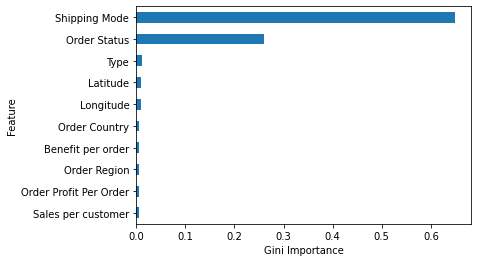

In [25]:
#looking at mt feature importances
importances = modelrf.named_steps['randomforestclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

In [28]:
#hyperparameter tuning using validation curves in the next few cells
samples = np.arange(.1,1.1,.1)
list(samples)

[0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

In [29]:
train_acc = []
val_acc = []

for sample in samples:

  rf_model = make_pipeline(
      OrdinalEncoder(),
      SimpleImputer(),
      RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=10, n_estimators=10, max_samples=1.0)
  )

  rf_model.fit(X_train, y_train)
  train_acc.append(rf_model.score(X_train, y_train))
  val_acc.append(rf_model.score(X_val, y_val))

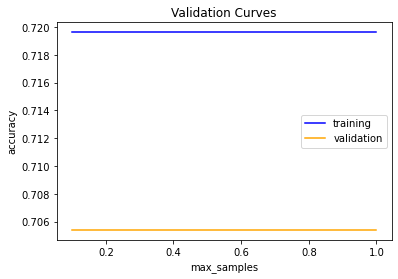

In [30]:
plt.plot(samples, train_acc, color='blue', label='training')
plt.plot(samples, val_acc, color='orange', label='validation')
plt.xlabel('max_samples')
plt.ylabel('accuracy')
plt.title('Validation Curves') # These plots are called VALIDATION CURVES! 
plt.legend()
plt.show()

###XGBClassifier###

In [26]:
#hyperparameter tuning using validation curves in the next few cells
rates = np.arange(.01,.1,.01)
list(rates)

[0.01,
 0.02,
 0.03,
 0.04,
 0.05,
 0.060000000000000005,
 0.06999999999999999,
 0.08,
 0.09]

In [27]:
train_acc = []
val_acc = []

for rate in rates:

  xgbmodel = make_pipeline(
      OrdinalEncoder(),
      XGBClassifier(n_jobs=-1,random_state=42,learning_rate=rate)
  )

  xgbmodel.fit(X_train, y_train)
  train_acc.append(xgbmodel.score(X_train, y_train))
  val_acc.append(xgbmodel.score(X_val, y_val))

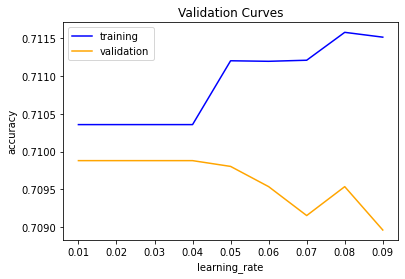

In [28]:
plt.plot(rates, train_acc, color='blue', label='training')
plt.plot(rates, val_acc, color='orange', label='validation')
plt.xlabel('learning_rate')
plt.ylabel('accuracy')
plt.title('Validation Curves') # These plots are called VALIDATION CURVES! 
plt.legend()
plt.show()

Text(0, 0.5, 'Feature')

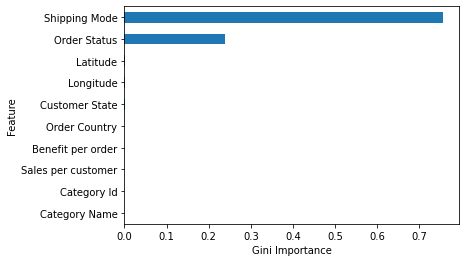

In [29]:
#feature importances of my xgbclassifier model
importances = modelxgb.named_steps['xgbclassifier'].feature_importances_
feature_names = X_train.columns
feat_imp = pd.Series(data=importances, index=feature_names).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')

In [31]:
#attaining permutation importances for my xgbclassifier model
perm_imp = permutation_importance(modelxgb, X_val, y_val, random_state=42)

In [32]:
data_perm = {'imp_mean': perm_imp['importances_mean'],
             'imp_std':perm_imp['importances_std']}

permdf = pd.DataFrame(data_perm, index=X_val.columns).sort_values('imp_mean')

permdf

,imp_mean,imp_std
Type,0.000000,0.000000
Product Name,0.000000,0.000000
Product Category Id,0.000000,0.000000
Product Card Id,0.000000,0.000000
Order Region,0.000000,0.000000
Order Profit Per Order,0.000000,0.000000
Order Item Total,0.000000,0.000000
Sales,0.000000,0.000000
Order Item Quantity,0.000000,0.000000
Order Item Profit Ratio,0.000000,0.000000


###Randomized CV Search XGBClassifier###

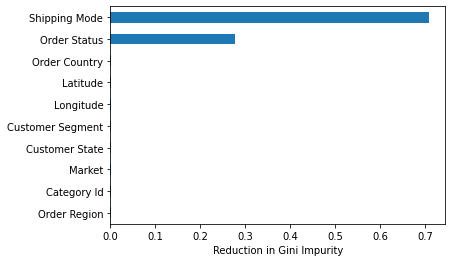

In [42]:
#looking at feature importances in my randomized cv search xgbclassifier model
bestimator = modelxgbrs.best_estimator_
importances = bestimator.named_steps['xgbclassifier'].feature_importances_
features = X_train.columns
feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Reduction in Gini Impurity');